```shell
conda create --name zarr python=3.9 numpy matplotlib zarr xarray ipykernel gcsfs fsspec dask

```

Explanation of the coordinates within the Zarr:

* time: The time the satellite image was taken, in UTC.
* variable: The satellite channel name. In the HRV dataset there is only one channel: The "high resolution visible" channel.
* x and y: The geospatial position of each pixel. In summary, the x and y values are the number of meters from south west corner of Great Britain. In more detail: the x and y values are "eastings" and "northings" in the "[OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey](https://epsg.io/27700)" grid reference system (EPSG 27700). See [this WikiPedia page for more information](https://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid#All-numeric_grid_references).

In [1]:
import xarray as xr
import pandas as pd

In [2]:
SOURCE_PATH = "gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/v2/*.zarr"

In [3]:
def drop_duplicate_times(data_array: xr.DataArray, time_dim: str = "time") -> xr.DataArray:
    """
    Drop duplicate times in data array
    Args:
        data_array: main data
        class_name: the data source name
        time_dim: the time dimension we want to look at
    Returns: data array with no duplicated times
    """
    # If there are any duplicated init_times then drop the duplicated init_times:
    time = pd.DatetimeIndex(data_array[time_dim])
    if not time.is_unique:
        n_duplicates = time.duplicated().sum()
        print(f"Zarr has {n_duplicates:,d} duplicated init_times.  Fixing...")
        data_array = data_array.drop_duplicates(dim=time_dim)
        
    assert pd.DatetimeIndex(data_array[time_dim]).is_unique

    return data_array

In [10]:
def remove_acq_time_from_dataset_and_dedupe_time_coords(dataset: xr.Dataset) -> xr.Dataset:
    """
    Preprocess datasets by dropping `acq_time`, which causes problems otherwise. Also de-duplicate time coords.

    Args:
        dataset: xr.Dataset to preprocess
    Returns:
        dataset with acq_time dropped
    """
    dataset = dataset.drop_vars("acq_time", errors="ignore")

    # If there are any duplicated init_times then drop the duplicated time:
    stacked_eumetsat_data = drop_duplicate_times(data_array=dataset["stacked_eumetsat_data"])

    dataset = stacked_eumetsat_data.to_dataset(name="stacked_eumetsat_data")
    assert pd.DatetimeIndex(stacked_eumetsat_data["time"]).is_unique
    assert pd.DatetimeIndex(stacked_eumetsat_data["time"]).is_monotonic_increasing
    return dataset


def open_hrv_data_array(source_path: str, use_same_chunks_as_zarr: bool = False) -> xr.DataArray:
    """Lazily open HRV data.
    
    Args:
      source_path: The path with the source Zarrs.
      use_same_chunks_as_zarr: If True then the returned DataArray will have the same chunk sizes
          as the Zarr stores. This is useful if copying the data to a new Zarr. If False then let
          dask automatically pick chunk sizes. This usually
          results in faster data access and processing.
    """
    dataset = xr.open_mfdataset(
        source_path,
        chunks={} if use_same_chunks_as_zarr else "auto",
        mode="r",
        engine="zarr",
        concat_dim="time",
        preprocess=remove_acq_time_from_dataset_and_dedupe_time_coords,
        combine="nested",
        consolidated=True
    )
    data_array = dataset["stacked_eumetsat_data"]
    data_array = data_array.sel(variable="HRV").drop_vars("variable")
    data_array = data_array.transpose("time", "y", "x")
    assert pd.DatetimeIndex(data_array["time"]).is_monotonic_increasing
    return data_array

In [11]:
%%time
data_array = open_hrv_data_array(SOURCE_PATH)

Zarr has 1 duplicated init_times.  Fixing...
Zarr has 1 duplicated init_times.  Fixing...
Zarr has 1 duplicated init_times.  Fixing...
Zarr has 1 duplicated init_times.  Fixing...
Zarr has 1 duplicated init_times.  Fixing...
Zarr has 8 duplicated init_times.  Fixing...
CPU times: user 49 s, sys: 2.97 s, total: 52 s
Wall time: 3min 30s


In [12]:
data_array

<xarray.DataArray 'stacked_eumetsat_data' (time: 173624, y: 891, x: 1843)>
dask.array<transpose, shape=(173624, 891, 1843), dtype=int16, chunksize=(40, 891, 1843), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float64 1.347e+06 1.346e+06 1.345e+06 ... -6.9e+05 -6.912e+05
  * y        (y) float64 -5.565e+05 -5.549e+05 ... 1.394e+06 1.397e+06
Attributes:
    meta:     {'orbital_parameters': {'projection_longitude': 9.5, 'projectio...

CPU times: user 785 ms, sys: 44.7 ms, total: 830 ms
Wall time: 917 ms


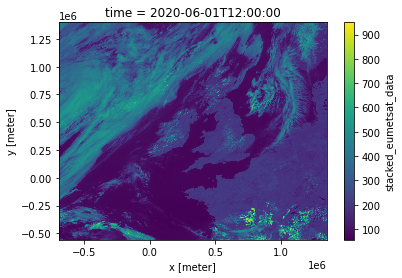

In [13]:
%%time
data_array.sel(time="2020-06-01 12:00").plot();

In [8]:
data_array.encoding

{'chunks': (1, 475, 450, 1),
 'preferred_chunks': {'time': 1, 'x': 475, 'y': 450, 'variable': 1},
 'compressor': Blosc(cname='zstd', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'dtype': dtype('int16'),
 'coordinates': 'acq_time'}

## Plot fancy map

See https://xarray.pydata.org/en/stable/user-guide/plotting.html#maps

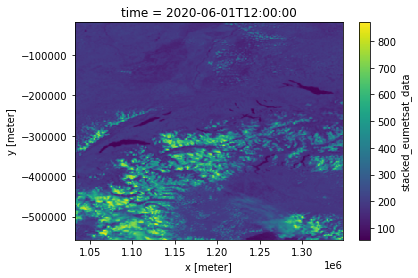

In [18]:
data_array.sel(time="2020-06-01 12:00").isel(x=slice(0, 300), y=slice(0, 300)).plot()

In [30]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

/tmp/ipykernel_10003/96029212.py:2: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.OSGB())


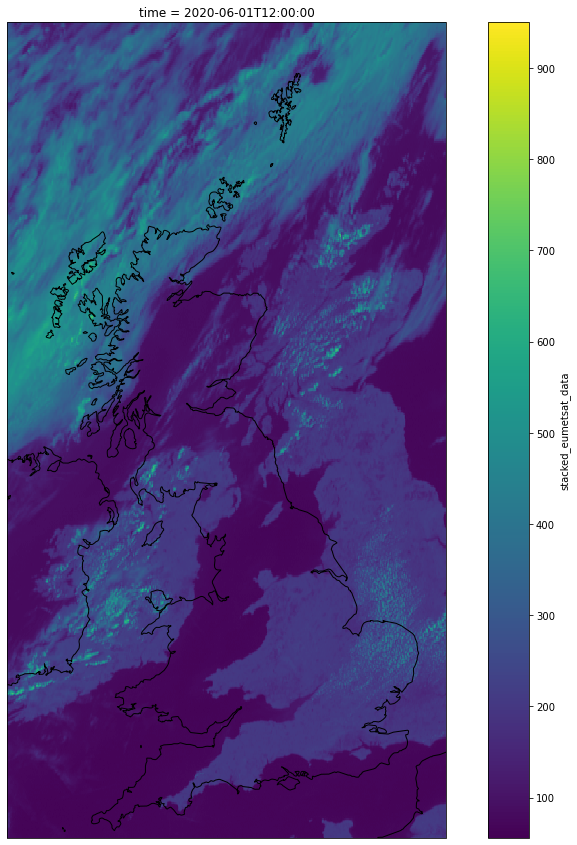

In [37]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.OSGB())
p = data_array.sel(time="2020-06-01 12:00").plot(ax=ax)
ax.coastlines()